# Proyecto II: Aprendizaje no supervisado

<strong>Estudiante:</strong> Mónica Gabriela Cabañas Meléndez 

### Importación de librerías necesarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

""" Factorización no negativa de matrices """
from sklearn.decomposition import NMF

## I. Sistema de recomendación

### Importación de datos

Los siguientes datos provienen de la base de datos de MovieLens que fue recuperada por el grupo de investigación GroupLens de la Universidad de Minesotta. Esta consiste en lo siguiente:
- 65,535 calificaciones de películas que van del 1 al 5 y que han sido realizadas por 943 usuarios. 
- Por cada usuario se tiene información demográfica básica (edad, género, ocupación, y código postal)

In [3]:
ratings = pd.read_excel(
    'data/u_data_ratings.xls', 
)

print('Cantidad de ratings: ', len(ratings))
ratings.head()

Cantidad de ratings:  65535


,User ID,Item ID,Rating,Unnamed: 3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
genres = pd.read_excel(
    'data/u_movies_genre.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de géneros: ', len(genres))
genres.head()

Cantidad de géneros:  19


,data
0,unknown|0
1,Action|1
2,Adventure|2
3,Animation|3
4,Children's|4


In [5]:
items = pd.read_excel(
    'data/u_movies_items.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de películas: ', len(items))
items.head()

Cantidad de películas:  1682


,data
0,1|Toy Story (1995)|01-Jan-1995||http://us.imdb...
1,2|GoldenEye (1995)|01-Jan-1995||http://us.imdb...
2,3|Four Rooms (1995)|01-Jan-1995||http://us.imd...
3,4|Get Shorty (1995)|01-Jan-1995||http://us.imd...
4,5|Copycat (1995)|01-Jan-1995||http://us.imdb.c...


In [6]:
occupations = pd.read_excel(
    'data/u_occupation.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de ocupaciones: ', len(occupations))
occupations.head()

Cantidad de ocupaciones:  21


,data
0,administrator
1,artist
2,doctor
3,educator
4,engineer


In [177]:
users = pd.read_excel(
    'data/u_user_info.xls', 
    header=None,
    names=['data'], 
)

print('Cantidad de usuarios: ', len(users))
users.head()

Cantidad de usuarios:  943


,data
0,1|24|M|technician|85711
1,2|53|F|other|94043
2,3|23|M|writer|32067
3,4|24|M|technician|43537
4,5|33|F|other|15213


Como podemos observar, algunos archivos (en específico users, items, y genres) contienen todos los datos en una sola columna separados por el caracter '|' por lo cual se procederá a realizar una transformación de estos datos para obtener matrices con las que podamos trabajar.

In [178]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in users:
    users[['Id', 'Age', 'Sex', 'Occupation', 'Zip Code']] = users["data"].str.split(pat="|", expand=True)

    # Eliminando la columna 'data'
    users.drop('data', axis='columns', inplace=True)

In [124]:
print('Cantidad de usuarios: ', len(users))
users.head()

Cantidad de usuarios:  943


,Id,Age,Sex,Occupation,Zip Code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [10]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in genres: 
    genres[['Name', 'Id']] = genres["data"].str.split(pat="|", expand=True)
    
    # Eliminando la columna 'data'
    genres.drop('data', axis='columns', inplace=True)
    genres = genres[['Id', 'Name']]

In [11]:
print('Cantidad de géneros: ', len(genres))
genres.head()

Cantidad de géneros:  19


,Id,Name
0,0,unknown
1,1,Action
2,2,Adventure
3,3,Animation
4,4,Children's


In [12]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in items:
        items[[
                'Id', 
                'Title', 
                'Release Date', 
                'Link', 
                'Genre 0', 
                'Genre 1', 
                'Genre 2', 
                'Genre 3', 
                'Genre 4', 
                'Genre 5', 
                'Genre 6', 
                'Genre 7', 
                'Genre 8', 
                'Genre 9', 
                'Genre 10', 
                'Genre 11', 
                'Genre 12', 
                'Genre 13', 
                'Genre 14', 
                'Genre 15', 
                'Genre 16', 
                'Genre 17', 
                'Genre 18']
        ] = items["data"].str.split(pat="\\|+", expand=True)

        # Eliminando la columna 'data'
        items.drop('data', axis='columns', inplace=True)

In [13]:
print('Cantidad de películas: ', len(items))
items.head()

Cantidad de películas:  1682


,Id,Title,Release Date,Link,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,...,Genre 9,Genre 10,Genre 11,Genre 12,Genre 13,Genre 14,Genre 15,Genre 16,Genre 17,Genre 18
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Transformación de edades

In [179]:
# Delimitando las edades a pocas categorías a fin de simplificar el análisis
bins = [-1, 11, 18, 30, 60, np.inf]                                         # Límites de edad
labels = ['Niños', 'Adolescentes', 'Jóvenes', 'Adultos', 'Tercera edad']    # Etiquetas

# Convertir 'Age' a numérico y aplicar pd.cut para clasificar edades
if 'Age' in users:
    users['Age Group'] = pd.cut(users['Age'].astype(int), bins=bins, labels=labels, right=True)

users

,Id,Age,Sex,Occupation,Zip Code,Age Group
0,1,24,M,technician,85711,Jóvenes
1,2,53,F,other,94043,Adultos
2,3,23,M,writer,32067,Jóvenes
3,4,24,M,technician,43537,Jóvenes
4,5,33,F,other,15213,Adultos
...,...,...,...,...,...,...
938,939,26,F,student,33319,Jóvenes
939,940,32,M,administrator,02215,Adultos
940,941,20,M,student,97229,Jóvenes
941,942,48,F,librarian,78209,Adultos


### Eliminación de ruido

In [180]:
# Encontrando usuarios que han calificado como mínimo 20 películas
if users['Id'].dtype != 'int':
    users['Id'] = users['Id'].astype(int)
    
if users.shape[0] == 943:
    print('Total de usuarios: ', users.shape[0])

# Contabilizando y filtrando usuarios en base a la cantidad de películas que han calificado
user_ratings = pd.merge(ratings, users, left_on='User ID', right_on='Id', how='inner')
user_ratings = user_ratings.groupby('User ID')['Rating'].agg('count')
users = users.loc[user_ratings[user_ratings > 20].index - 1, :]
users.index.name = None

print('Cantidad de usuarios que han calificado al menos 20 películas: ', users.shape[0])

Total de usuarios:  943
Cantidad de usuarios que han calificado al menos 20 películas:  671


In [110]:
""" # Obteniendo ratings mayores a 3
filtered_ratings = ratings[ratings['Rating'] > 3] 
# Agrupando por id de usuario para tener un arreglo de las películas que le gustaron
user_items = filtered_ratings.groupby('User ID')['Item ID'].apply(list).reset_index()

# Obteniendo los nombres de las columnas de géneros
genre_columns = [f'Genre {i}' for i in range(19)]

user_items[genre_columns] = 0

if items['Id'].dtype != 'int':
    items['Id'] = items['Id'].astype(int)

# Obteniendo los géneros de las películas que le gustaron a los usuarios
for i in range(len(user_items)):
    # Convirtiendo la lista de películas a un DataFrame
    movies = pd.DataFrame(user_items['Item ID'].loc[i], columns=['Item ID'])

    # Realizando un merge con el DataFrame de películas
    movies = pd.merge(movies, items, left_on='Item ID', right_on='Id', how='inner')
    genres_list = []

    # Iterando sobre las columnas de géneros y verificando si dicho género está presente en la película
    for genre in genre_columns:
        count_ones = movies[genre].value_counts().get('1')
        
        if count_ones is not None:
            user_items.at[i, genre] = 1
    
# Uniendo a la tabla principal de usuarios
users = pd.merge(user_items, users, left_on='User ID', right_on='Id', how='inner')

if 'User ID' in users:
    users.drop('User ID', axis='columns', inplace=True)
if 'Item ID' in users:
    users.drop('Item ID', axis='columns', inplace=True)
users.head() """

" # Obteniendo ratings mayores a 3\nfiltered_ratings = ratings[ratings['Rating'] > 3] \n# Agrupando por id de usuario para tener un arreglo de las películas que le gustaron\nuser_items = filtered_ratings.groupby('User ID')['Item ID'].apply(list).reset_index()\n\n# Obteniendo los nombres de las columnas de géneros\ngenre_columns = [f'Genre {i}' for i in range(19)]\n\nuser_items[genre_columns] = 0\n\nif items['Id'].dtype != 'int':\n    items['Id'] = items['Id'].astype(int)\n\n# Obteniendo los géneros de las películas que le gustaron a los usuarios\nfor i in range(len(user_items)):\n    # Convirtiendo la lista de películas a un DataFrame\n    movies = pd.DataFrame(user_items['Item ID'].loc[i], columns=['Item ID'])\n\n    # Realizando un merge con el DataFrame de películas\n    movies = pd.merge(movies, items, left_on='Item ID', right_on='Id', how='inner')\n    genres_list = []\n\n    # Iterando sobre las columnas de géneros y verificando si dicho género está presente en la película\n    f

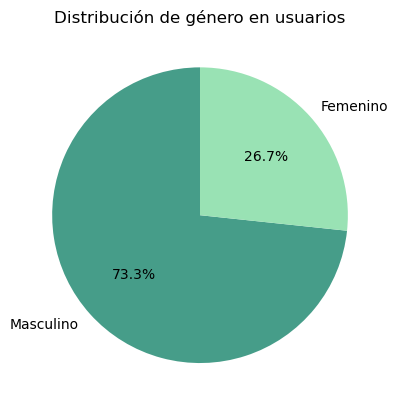

In [164]:
sex_labels = ['Masculino', 'Femenino']
sex_values = [(users['Sex'] == 'M').sum(), (users['Sex'] == 'F').sum()]

# Gráfico de pastel para género
plt.pie(x=sex_values, labels=sex_labels, autopct='%1.1f%%', startangle=90, colors=['#469D89', '#99E2B4'])
plt.title('Distribución de género en usuarios')
plt.show()

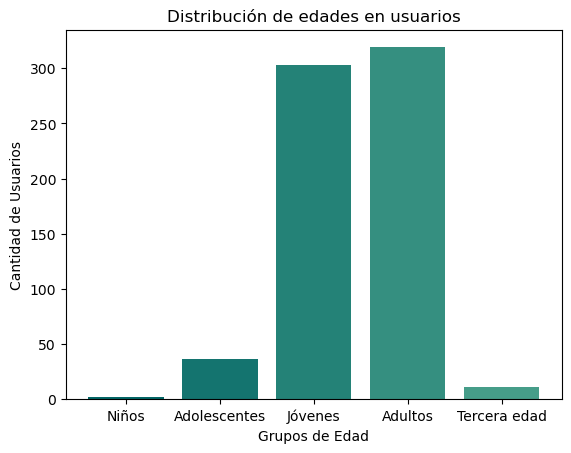

In [165]:
age_labels = ['Niños', 'Adolescentes', 'Jóvenes', 'Adultos', 'Tercera edad']
age_values = [
    (users['Age Group'] == 'Niños').sum(),
    (users['Age Group'] == 'Adolescentes').sum(),
    (users['Age Group'] == 'Jóvenes').sum(),
    (users['Age Group'] == 'Adultos').sum(),
    (users['Age Group'] == 'Tercera edad').sum()
]

# Gráfico de barras para edades
plt.bar(age_labels, age_values, color=['#036666', '#14746F', '#248277', '#358F80', '#469D89'])
plt.title('Distribución de edades en usuarios')
plt.xlabel('Grupos de Edad')
plt.ylabel('Cantidad de Usuarios')
plt.show()

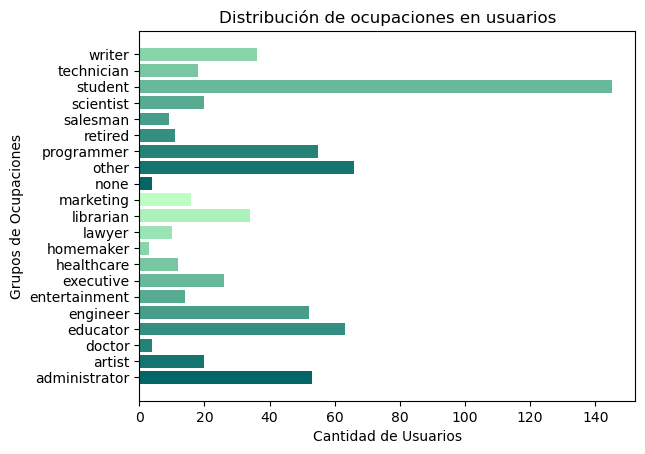

In [166]:
occupation_labels = list(occupations['data'])
occupation_values = [users['Occupation'].value_counts().get(label, 0) for label in occupation_labels]

# Gráfico de barras para ocupaciones
plt.barh(occupation_labels, occupation_values, color=['#036666', '#14746F', '#248277', '#358F80', '#469D89', '#56AB91', 
                                                      '#67B99A', '#78C7A2', '#89D5AB', '#9AE3B4', '#ABF1BC', '#BCFFC5'])
plt.title('Distribución de ocupaciones en usuarios')
plt.ylabel('Grupos de Ocupaciones')
plt.xlabel('Cantidad de Usuarios')

plt.show()

Como podemos observar a través de las gráficas anteriores la mayor cantidad de usuarios se concentra:
- Sexo: la mayoría son de sexo masculino y la minoría de sexo femenino.
- Grupo de edad: la mayoría se concentra entre los jóvenes y adultos mientras que la minoría se encuentra en el grupo de los niños y los adultos mayores.
- Ocupación: los estudiantes son la gran mayoría en este caso de estudio.

### Transformación de datos
Procederemos ahora a realizar la tranformación de los datos categóricos a numéricos para que estos puedan ser procesados por los algoritmos de procesamiento, en específico el de KMeans. Primero verificaremos que no hayan valores nulos.

In [167]:
# Verificando que no haya valores nulos
nulos = users.isnull().sum()
print(nulos)

Id            0
Age           0
Sex           0
Occupation    0
Zip Code      0
Age Group     0
dtype: int64


Dado que se trata de caracteríticas categóricas deberemos transformar los datos en algo que los algoritmos de clustering puedan manejar. Existen varias formas para realizar lo anterior: 

#### 1. Category encoding
Este término es general y abarca cualquier técnica que transforme categorías no numéricas (como "rojo", "verde", "azul") en valores numéricos que los modelos puedan procesar.
Este método puede ser contraproducente cuando se aplica en categorías no ordinales dado que introduce un enfoque de ordenamiento que no es representativo. 

#### 2. One-hot encoding
Cada categoría se transforma en una columna binaria (0 o 1) separada. Este método evita el problema de asignar un valor ordinal a categorías que no tienen un orden lógico. Se crea una matriz de 0s y 1s en la que cada fila tiene un único 1, y el resto son 0s. Sin embargo, cunado se quiere utilizar algoritmos que aplican la distancia euclidiana como KMeans este método de codificación no es muy beneficioso dado que al calcular la distancia euclideana entre dos valores siempre será la misma: $ \sqrt{2} = 1.41$

Para el caso de 3 posibles categorías: $ (1, 0, 0), (0, 1, 0) $
$$
    \sqrt{(1-0)^{2} + (0-1)^2 + (0-0)^2} = \sqrt{2} = 1.41
$$

Para el caso de 5 posibles categorías: $ (1, 0, 0, 0, 0), (0, 1, 0, 0, 0) $
$$
    \sqrt{(1-0)^{2} + (0-1)^2 + (0-0)^2 + (0-0)^2 + (0-0)^2} = \sqrt{2} = 1.41
$$

#### 3. One-over-n-hot encoding
Este método es una extensión del anterior que igualmente utiliza vectores pero en vez de asignar un 1 en el índice de la categoría correspondiente se asigna un valor entre 0 y 1 que corresponde a $\frac{1}{n}$ y de esta manera cuando se hace el cálculo de la distancia euclidiana los resultados no serán los mismos para categorías con distintos posibles valores.

Para el caso de 3 posibles categorías: $ (0.33, 0, 0), (0, 0.33, 0) $
$$
    \sqrt{(0.33-0)^{2} + (0-0.33)^2 + (0-0)^2} = 0.47
$$

Para el caso de 5 posibles categorías: $ (0.2, 0, 0, 0, 0), (0, 0.2, 0, 0, 0) $
$$
    \sqrt{(0.2-0)^{2} + (0-0.2)^2 + (0-0)^2 + (0-0)^2 + (0-0)^2} = 0.28
$$

#### 4. Equal interval encoding
Este método se puede utilizar para casos en que se traten de variables categóricas que tienen un ordenamiento subyacente como es el caso de la altura, grupos de edades, entre otros. En general, los valores asignados pueden ser calculados de la siguiente manera: 

$$
\frac{i}{(n+1)}
$$

Siendo $ i $ el índice asignado a la categoría acorde al ordenamiento subyacente. Por ejemplo, para tres posibles alturas:
- 'pequeño' = $\frac{1}{(3+1)} = 0.25$
- 'medio' = $\frac{2}{(3+1)} = 0.50$
- 'alto' = $\frac{3}{(3+1)} = 0.75$

Empezaremos entonces con la transformación de los datos, iniciando con la variable de ocupaciones que cuenta con 21 posibilidades independientes entre sí y dado que se utilizará KMeans como algoritmo de agrupamiento utilizaremos one-over-n-hot encoding.

In [181]:
# Aplicamos One-hot encoding a la columna 'Occupation'
if 'Occupation' in users:
    users = pd.get_dummies(users, columns=['Occupation'], dtype=float)

# Obteniendo el número de columnas generadas por get_dummies
num_occupations = users.filter(like='Occupation_').shape[1]

# Sustituyendo los valores 1 por 1/num_occupations y así aplicando One-over-n-hot encoding
for i in users[users == 1].stack().index:
    users.loc[i] = (float) (1/num_occupations)

users

C:\Users\monic\AppData\Local\Temp\ipykernel_13860\1571537283.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.047619047619047616' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  users.loc[i] = (float) (1/num_occupations)


,Id,Age,Sex,Zip Code,Age Group,Occupation_administrator,Occupation_artist,Occupation_doctor,Occupation_educator,Occupation_engineer,...,Occupation_marketing,Occupation_none,Occupation_other,Occupation_programmer,Occupation_retired,Occupation_salesman,Occupation_scientist,Occupation_student,Occupation_technician,Occupation_writer
0,0.047619,24,M,85711,Jóvenes,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.047619,0.000000
1,2.000000,53,F,94043,Adultos,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,3.000000,23,M,32067,Jóvenes,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.047619
4,5.000000,33,F,15213,Adultos,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
5,6.000000,42,M,98101,Adultos,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,882.000000,35,M,40503,Adultos,0.0,0.0,0.0,0.0,0.047619,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
882,883.000000,49,M,50266,Adultos,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
885,886.000000,20,M,61820,Jóvenes,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.047619,0.000000,0.000000
888,889.000000,24,M,78704,Jóvenes,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.047619,0.000000


Para el caso del sexo que es una variable binaria aplicaremos un caso especial de one-over-n-hot encoding: Attenuated one-over-n-hot encoding el cual explica James McCafrrey en el siguiente artículo: <a href="https://visualstudiomagazine.com/Articles/2024/05/15/clustering-mixed-categorical-and-numeric-data.aspx">Clustering Mixed Categorical and Numeric Data Using k-Means with C#</a> que en varios experimentos la sola aplicación de one-over-n-hot encoding en variables binarias no se ha comportado tan bien como con attenuated encoding: <em>"In some experiments, the plain one-over-n-hot encoding for binary categorical data did not work as well as the attenuated encoding. But results were not conclusive and how best to encode binary categorical data is an open research question."</em>

Aplicando attenuated encoding en el sexo las categorías se sustituirían de la siguiente manera: 
- M = 0.5
- F = 0.0

In [182]:
for i in users[users == 'M'].stack().index:
    """ users.loc[i] = 1.0 """
    users.loc[i] = 0.5

for i in users[users == 'F'].stack().index:
    users.loc[i] = 0.0

users.head()

,Id,Age,Sex,Zip Code,Age Group,Occupation_administrator,Occupation_artist,Occupation_doctor,Occupation_educator,Occupation_engineer,...,Occupation_marketing,Occupation_none,Occupation_other,Occupation_programmer,Occupation_retired,Occupation_salesman,Occupation_scientist,Occupation_student,Occupation_technician,Occupation_writer
0,0.047619,24,0.5,85711,Jóvenes,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.047619,0.000000
1,2.000000,53,0.0,94043,Adultos,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,3.000000,23,0.5,32067,Jóvenes,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.047619
4,5.000000,33,0.0,15213,Adultos,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
5,6.000000,42,0.5,98101,Adultos,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


Las edades, al ser valores numéricos no será necesario codificarlas, pero dado que las demás características se encuentran entre el 0 y el 1 será necesario normalizarlas con MinMax para que se encuentren en la misma escala que las demás características. A cada valor de la edad se le aplicará la siguiente expresión: 

$$
    \frac{X - X_{min}}{X_{max} - X_{min}}
$$

In [184]:
""" from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
users['Age'] = scaler.fit_transform(users['Age'].values.reshape(-1, 1)) """

# Aplicamos One-hot encoding a la columna 'Age Group'
if 'Age Group' in users:
    users = pd.get_dummies(users, columns=['Age Group'], dtype=float)

# Obteniendo el número de columnas generadas por get_dummies
num_age_groups = users.filter(like='Age Group_').shape[1]

# Sustituyendo los valores 1 por 1/num_age_groups y así aplicando One-over-n-hot encoding
for i in users[users == 1].stack().index:
    users.loc[i] = 1/num_age_groups

users.head()

,Id,Age,Sex,Zip Code,Occupation_administrator,Occupation_artist,Occupation_doctor,Occupation_educator,Occupation_engineer,Occupation_entertainment,...,Occupation_salesman,Occupation_scientist,Occupation_student,Occupation_technician,Occupation_writer,Age Group_Niños,Age Group_Adolescentes,Age Group_Jóvenes,Age Group_Adultos,Age Group_Tercera edad
0,0.047619,24,0.5,85711,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.047619,0.000000,0.0,0.0,0.2,0.0,0.0
1,2.000000,53,0.0,94043,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.2,0.0
2,3.000000,23,0.5,32067,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.047619,0.0,0.0,0.2,0.0,0.0
4,5.000000,33,0.0,15213,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.2,0.0
5,6.000000,42,0.5,98101,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.2,0.0


In [185]:
# Eliminando columnas que no se utilizarán para el análisis
if 'Id' in users:
    users.drop('Id', axis='columns', inplace=True)
if 'Age' in users:
    users.drop('Age', axis='columns', inplace=True)
if 'Zip Code' in users:
    users.drop('Zip Code', axis='columns', inplace=True)

users

,Sex,Occupation_administrator,Occupation_artist,Occupation_doctor,Occupation_educator,Occupation_engineer,Occupation_entertainment,Occupation_executive,Occupation_healthcare,Occupation_homemaker,...,Occupation_salesman,Occupation_scientist,Occupation_student,Occupation_technician,Occupation_writer,Age Group_Niños,Age Group_Adolescentes,Age Group_Jóvenes,Age Group_Adultos,Age Group_Tercera edad
0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.047619,0.000000,0.0,0.0,0.2,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.2,0.0
2,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.047619,0.0,0.0,0.2,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.2,0.0
5,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.047619,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,0.5,0.0,0.0,0.0,0.0,0.047619,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.2,0.0
882,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.2,0.0
885,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.047619,0.000000,0.000000,0.0,0.0,0.2,0.0,0.0
888,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.047619,0.000000,0.0,0.0,0.2,0.0,0.0


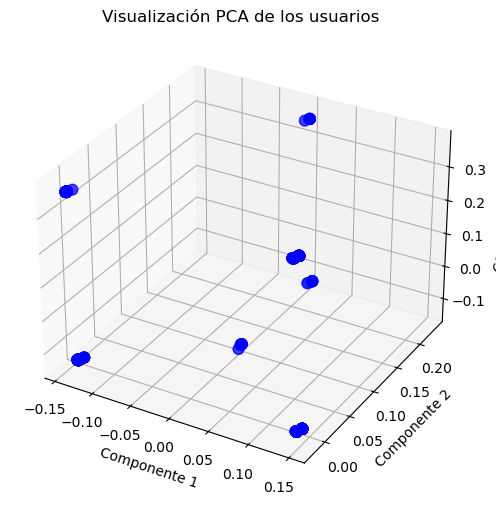

In [186]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 2 dimensiones
pca = PCA(n_components=3)
pca_components = pca.fit_transform(users)

# Graficar los resultados en 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_components[:, 1], pca_components[:, 2], pca_components[:, 0], c='blue', s=60)
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.set_title('Visualización PCA de los usuarios')
plt.show()

In [187]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto', random_state=0).fit(users)
    print('Silhouette Score para', i, 'clusters:', silhouette_score(users, kmeans.labels_))

Silhouette Score para 2 clusters: 0.6521501623346508
Silhouette Score para 3 clusters: 0.6758744505991928
Silhouette Score para 4 clusters: 0.6938823645371139
Silhouette Score para 5 clusters: 0.7443306311692781
Silhouette Score para 6 clusters: 0.7736372930508385
Silhouette Score para 7 clusters: 0.7987960609120976
Silhouette Score para 8 clusters: 0.5764920039001438
Silhouette Score para 9 clusters: 0.6227717933890884
Silhouette Score para 10 clusters: 0.6280348095179368


### NMF

A continuación crearemos la matriz $V$ que estará compuesta por la combinación de los usuarios con las películas y las calificaciones serán los valores de cada celda. Cada usuario será una observación y cada película una característica.

In [190]:
user_rating_counts = ratings['User ID'].value_counts()
print('Cantidad de usuarios con ratings: ', user_rating_counts.shape)

Cantidad de usuarios con ratings:  (916,)


In [191]:
item_rating_counts = ratings['Item ID'].value_counts()
print('Cantidad de películas con ratings: ', item_rating_counts.shape)

Cantidad de películas con ratings:  (1626,)


No todas las películas han sido calificadas y no todos los usuarios han calificado por lo cual hay que indicar esos valores vacíos con algo representativo. En este caso indicaremos los valores vacíos con $-1$ para luego sustituirlos por otro valor arbitrario con el cual podamos iniciar NMF.

In [192]:
# Crear la matriz usuario-película
user_movie_matrix = ratings.pivot_table(columns='Item ID', index='User ID', values='Rating', fill_value=-1)

print('Dimensiones de la matriz usuario-película: ', user_movie_matrix.shape)
user_movie_matrix.head()

Dimensiones de la matriz usuario-película:  (916, 1626)


Item ID,1,2,3,4,5,6,7,8,9,10,...,1655,1656,1657,1658,1660,1661,1662,1663,1664,1669
User ID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,-1.0,3.0,3.0,5.0,-1.0,1.0,5.0,3.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,4.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Eliminando ruido

Existen muchos usuarios que no han votado como mínimo 20 películas y algunas películas que no han sido votadas por al menos 10 usuarios, por lo cual eliminaremos dichos elementos del dataset para evitar ruido en el mismo. En las siguientes gráficas podremos observar los elementos que están por debajo de la línea roja no cumplen con el mínimo establecido (20 películas calificadas por usuario y que una película haya sido calificada por lo menos por 10 usuarios).

In [193]:
movies_votes_counts = ratings.groupby('Item ID')['Rating'].agg('count')
user_votes_counts = ratings.groupby('User ID')['Rating'].agg('count')

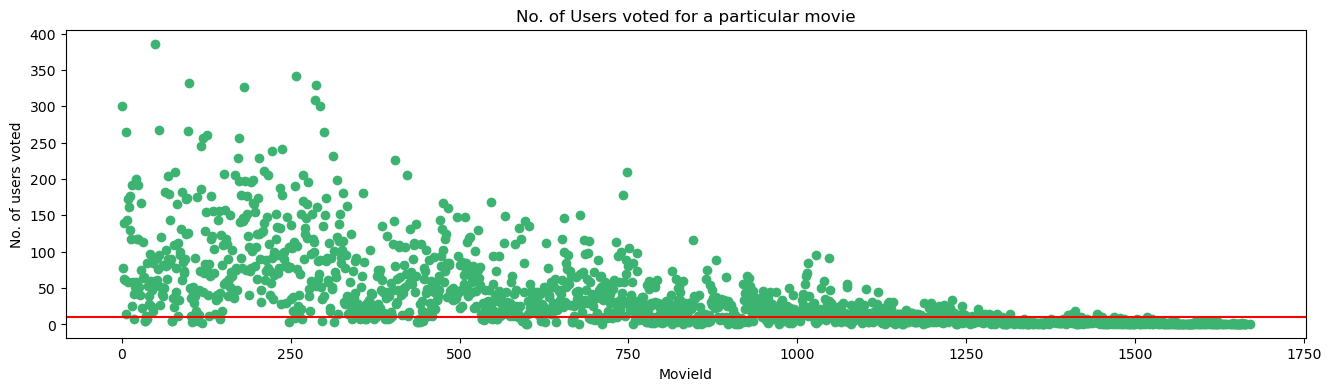

In [194]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(movies_votes_counts.index, movies_votes_counts,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.title('No. of Users voted for a particular movie')
plt.show()

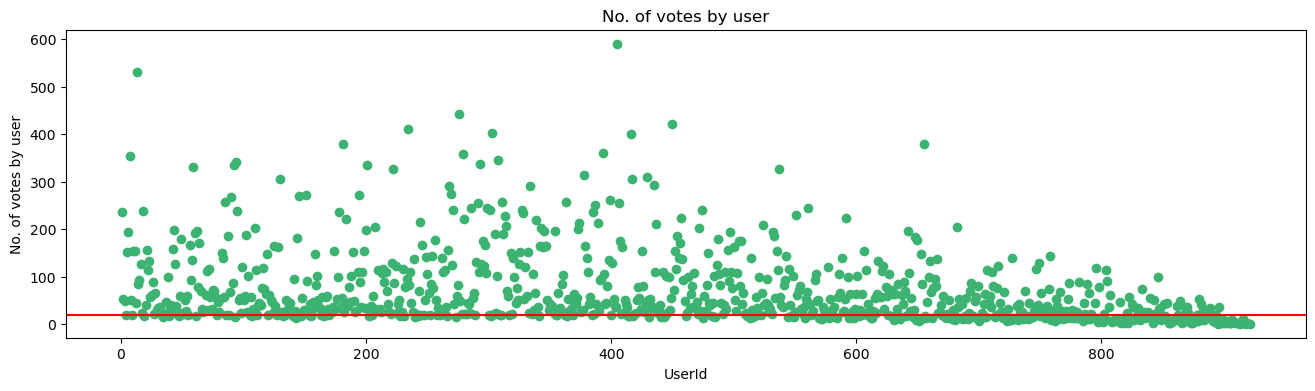

In [195]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(user_votes_counts.index, user_votes_counts,color='mediumseagreen')
plt.axhline(y=20,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.title('No. of votes by user')
plt.show()

In [196]:
user_movie_matrix = user_movie_matrix.loc[user_votes_counts[user_votes_counts > 20].index, :]
user_movie_matrix = user_movie_matrix.loc[:, movies_votes_counts[movies_votes_counts > 10].index]
print('Dimensiones de la matriz usuario-película: ', user_movie_matrix.shape)
user_movie_matrix.head()

Dimensiones de la matriz usuario-película:  (671, 1001)


Item ID,1,2,3,4,5,6,7,8,9,10,...,1280,1283,1286,1296,1315,1401,1407,1411,1444,1446
User ID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,-1.0,3.0,3.0,5.0,-1.0,1.0,5.0,3.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,4.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,4.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Ahora que hemos eliminado el ruido, antes de aplicar NMF debemos lidiar con los valores vacíos (que por el momento hemos dejado indicados como -1). En el artículo <a href="https://archive.siam.org/meetings/sdm06/proceedings/059zhangs2.pdf">Learning from Incomplete Ratings Using Non-negative Matrix Factorization</a> se describen tres variaciones de NMF que han resultado efectivas para trabajar con ratings incompletos como el de este caso:
- <b>Expectation Maximization (EM):</b> Este método estima los valores faltantes utilizando una técnica iterativa. En cada iteración, los ratings faltantes se reemplazan con las predicciones actuales, y luego se aplica NMF a la matriz completa para mejorar el modelo.

- <b>Weighted Non Negative Matrix Factorization (WNMF):</b> Introduce un factor de ponderación para los datos observados, lo que permite diferenciar entre ratings conocidos y faltantes. Aquí, las entradas conocidas tienen un peso mayor que las faltantes en el proceso de factorización.

- <b>Enfoque híbrido:</b> Combina ambos métodos, iniciando con algunas iteraciones del algoritmo EM y refinando el modelo final con WNMF. Este enfoque es más rápido y efectivo para obtener predicciones precisas, ya que evita depender de inicializaciones aleatorias que pueden afectar la calidad del modelo.

En este trabajo se ha implementado únicamente Expectation Maximization (EM).

In [197]:
def initialize_missing_values(matrix, init_value=0):
    # Reemplaza los valores faltantes (-1) con init_value
    filled_matrix = matrix.copy()
    filled_matrix[filled_matrix == -1] = init_value
    return filled_matrix

def em_nmf(matrix, n_components, max_iter=5):
    # Inicializamos los valores faltantes con 0 y aplicamos NMF con EM
    filled_matrix = initialize_missing_values(matrix, 0)
    nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=1000)

    # Aplicamos NMF iterativamente y actualizamos los valores faltantes con la estimación de NMF
    for i in range(max_iter):
        W = nmf.fit_transform(filled_matrix)
        H = nmf.components_
        estimated_matrix_em = pd.DataFrame(np.dot(W, H), columns=matrix.columns, index=matrix.index)

        filled_matrix[matrix == -1] = estimated_matrix_em[matrix == -1]

    return estimated_matrix_em, W, H

estimated_em, W, H = em_nmf(user_movie_matrix, 19)

In [198]:
W = pd.DataFrame(W, index=user_movie_matrix.index)
W

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
User ID,,,,,,,,,,,,,,,,,,,
1,0.900017,1.481001,0.452358,0.674934,0.435925,0.000000,0.000000,0.000000,0.153380,0.388331,0.480308,1.296893,0.989976,0.158329,0.405849,0.456554,0.070968,0.017411,0.658083
2,0.000000,0.000000,0.000000,1.097989,0.000000,0.000000,0.193286,0.228554,0.000000,0.000000,0.000000,0.251336,0.000000,0.150934,0.000000,0.050591,0.590846,0.049555,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.381525,0.000000,0.000000,0.036801,0.023289,0.000000,0.098756,0.230443,0.106283,0.000000,0.482024,0.090861,0.000000
5,0.000000,0.000000,1.045210,0.000000,0.580796,0.000000,0.000000,0.000000,1.405890,0.968790,0.000000,0.000000,0.699227,0.305675,0.000000,0.000000,0.000000,0.510248,0.006350
6,1.349156,0.000000,0.410872,0.324786,0.098343,1.506282,0.000000,0.031625,0.240942,0.000000,0.570757,1.231610,0.000000,0.161760,0.578311,0.000000,0.195244,0.965286,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,0.797134,0.000000,1.710672,0.000225,0.000000,0.000000,0.000000,0.155425,0.580347,0.000000,0.038851,0.000000,0.000000,0.116314,0.000000,0.187280,0.000000,0.000000,0.000000
883,0.006718,0.080551,0.000000,0.096975,0.094015,0.000000,0.000000,0.000000,0.540114,0.582197,0.000000,1.013950,0.041447,0.250435,0.000000,0.000000,0.011549,0.000000,0.055674
886,1.885995,0.000000,0.256608,0.000000,0.157983,0.000000,0.000000,0.088143,0.089733,0.000000,0.000000,0.000000,0.327873,0.000000,0.000000,0.000000,0.000000,0.000000,0.094315


In [199]:
H = pd.DataFrame(H, columns=user_movie_matrix.columns)
H

Item ID,1,2,3,4,5,6,7,8,9,10,...,1280,1283,1286,1296,1315,1401,1407,1411,1444,1446
0,0.146752,0.011106,0.078400,0.565029,0.066068,0.000000,0.565674,0.478708,0.333647,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.029166,0.063791,0.375576,0.241083,0.288187,0.005337,0.064903,0.134167,0.315638,0.234446,...,0.000000,0.000000,0.000000,0.052630,0.000000,0.038281,0.000000,0.032166,0.009616,0.000000
2,0.722806,0.027263,0.000000,0.004117,0.012922,0.000000,0.057709,0.740250,0.083920,0.000000,...,0.026055,0.000000,0.000000,0.000000,0.000000,0.028650,0.000000,0.000000,0.228659,0.000000
3,2.355865,0.000000,0.726163,0.000000,0.000000,0.610132,2.735210,0.000000,3.321509,1.479089,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060099,0.000000,0.000000,0.000000
4,3.366166,2.310737,0.655492,1.070333,0.000000,0.000000,3.819962,0.358144,0.000000,1.208248,...,0.220573,0.000000,0.000000,0.000000,0.000000,1.072957,0.000000,2.028675,0.000000,0.511910
5,0.351405,0.000000,0.000000,0.311945,0.002504,0.148079,0.421228,0.542120,0.378891,1.029711,...,0.000000,0.000000,0.748285,0.000000,0.000000,0.171958,0.000000,0.294122,0.375840,0.071672
6,0.016059,0.000000,0.000000,0.000000,0.000000,0.036862,0.138876,0.000000,0.080667,0.000000,...,0.121605,0.000000,0.000000,0.375790,0.105099,0.000000,0.000000,0.000000,0.000000,0.000000
7,3.956486,0.167612,1.626968,0.000000,1.368157,0.000000,2.700860,0.515044,2.255690,0.732389,...,0.000000,1.523796,0.000000,0.000000,1.212701,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.191472,0.000000,0.093865,0.915048,0.000000,0.000000,0.010456,0.952529,0.041098,0.000000,...,0.000000,0.066552,0.018012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.017305,0.013623,0.000000,0.000000,1.178991,0.000000,1.095085,0.000000,0.000000,0.001752,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043723,0.000000


In [200]:
estimated_em = pd.DataFrame(estimated_em, columns=user_movie_matrix.columns, index=user_movie_matrix.index)
estimated_em

Item ID,1,2,3,4,5,6,7,8,9,10,...,1280,1283,1286,1296,1315,1401,1407,1411,1444,1446
User ID,,,,,,,,,,,,,,,,,,,,,
1,4.652955,3.401759,2.632652,3.702223,1.910683,1.367358,5.768210,3.185597,5.342735,3.467250,...,0.385957,0.250263,0.591433,0.360234,0.419614,1.352455,0.839691,1.294625,0.188446,0.753221
2,4.111160,0.060130,1.174496,0.071190,0.346377,0.860697,3.915433,0.354844,4.323305,2.037254,...,0.652719,0.360174,0.027754,0.548642,0.305836,0.069709,0.095251,0.009180,0.015407,0.039175
3,0.861195,0.123142,0.158402,0.190172,0.076072,0.050926,0.536950,0.295049,0.229183,0.081315,...,0.701409,0.023489,0.136401,0.877871,0.241412,0.047210,0.055345,0.086074,0.019631,0.059624
5,4.143412,1.810341,1.279682,2.406226,1.383638,0.000000,3.841872,2.583847,0.262527,0.779328,...,0.297915,0.189137,0.184683,0.000000,0.015225,0.896843,0.371627,1.381159,0.382561,0.677669
6,3.386161,0.716907,0.829894,2.654973,0.194955,1.321164,3.606445,3.932034,3.993938,3.805170,...,0.240298,0.165789,1.978458,0.369743,0.575932,0.709531,0.265051,1.114815,0.851531,0.461552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2.425999,0.139297,0.373292,1.093388,0.401927,0.000137,1.101211,2.448375,0.930012,0.117501,...,0.044814,0.280807,0.064886,0.000000,0.213934,0.107895,0.016685,0.000000,0.411809,0.087389
883,1.512203,0.369408,0.256281,0.817098,0.755797,0.800502,1.886988,1.221956,0.895073,1.254027,...,0.041486,0.048658,0.011210,0.180062,0.000000,0.335458,0.111154,0.199743,0.026230,0.061171
886,1.437452,0.771899,0.741478,1.597815,0.398134,0.000000,2.027912,1.315611,0.955189,0.276141,...,0.108387,0.185716,0.013334,0.000000,0.106891,0.291147,0.171082,0.371322,0.058676,0.184059


Las tablas anteriores representan las matrices W, H, y la estimación de V al realizar la multiplicación de W y H. Las celdas que antes estaban vacías ahora tienen valores numéricos mayores a 0 y que pueden ser interpretados como las calificaciones estimadas que daría un usuario en caso calificara tal película; esto puede ser utilizado para recomendar las películas que el sistema estima que el usuario calificaría como mejores.

Ya que tenemos nuestro sistema de recomendaciones procederemos a realizar recomendaciones personalizadas a cada usuario basado en las calificaciones que ha dado a una serie de películas.

#### Para usuarios existentes en la base de datos

In [201]:
def get_recommendations(user_id, n_recommendations=10, estimated_em=estimated_em):
    # Corremos el algoritmo de NMF con EM por si se trata de un usuario recientemente registrado
    if user_id not in user_movie_matrix.index:
        print('El usuario no ha realizado ratings')
        return None
    elif user_id in user_movie_matrix.index and (user_movie_matrix.loc[user_id] == -1).any():
        estimated_matrix_em, W, H = em_nmf(user_movie_matrix, 19)
    else:
        estimated_matrix_em = estimated_em

    # Obtenemos las recomendaciones para el usuario
    movies_id = estimated_matrix_em.loc[user_id].sort_values(ascending=False).index
    movies_id = pd.DataFrame(movies_id, columns=['Item ID'])
    user_recommendations = movies_id.merge(items, left_on='Item ID', right_on='Id', how='inner')[['Id', 'Title', 'Release Date']].head(n_recommendations)

    return user_recommendations, estimated_matrix_em

In [202]:
# Puedes cambiar el id del usuario para obtener recomendaciones
user_id = 2
recommendations, estimated_em = get_recommendations(user_id, estimated_em=estimated_em)
recommendations

,Id,Title,Release Date
0,302,L.A. Confidential (1997),01-Jan-1997
1,268,Chasing Amy (1997),01-Jan-1997
2,269,"Full Monty, The (1997)",01-Jan-1997
3,100,Fargo (1996),14-Feb-1997
4,276,Leaving Las Vegas (1995),01-Jan-1995
5,313,Titanic (1997),01-Jan-1997
6,286,"English Patient, The (1996)",15-Nov-1996
7,340,Boogie Nights (1997),01-Jan-1997
8,50,Star Wars (1977),01-Jan-1977
9,272,Good Will Hunting (1997),01-Jan-1997


#### Para usuarios que no están en la base de datos

In [203]:

import ipywidgets as widgets

# Seleccionar películas aleatorias para calificar
quantity = 20
random_movies_id = pd.DataFrame(np.random.choice(user_movie_matrix.columns, quantity, replace=False), columns=['Item ID'])
random_movies = random_movies_id.merge(items, left_on='Item ID', right_on='Id', how='inner')[['Id','Title', 'Release Date']]
options = [1, 2, 3, 4, 5]

# Crear widgets para calificar las películas
print('Por favor, califique las siguientes películas:')
widgets_array = []
for i in range(quantity):
    widget = widgets.Box(
        [
            widgets.Label(value='Película: ' + random_movies['Title'].loc[i]),
            widgets.RadioButtons(
                    options=options,
                )
        ]
    )
    widgets_array.append(widget)
    display(widget)

# Obtener las calificaciones de las películas
def get_user_ratings(widgets_array, movies_id):
    user_ratings = []
    for i in range(5):
        movie_rating = {
            'item_id': movies_id['Item ID'].loc[i],
            'rating': widgets_array[i].children[1].value
        }
        user_ratings.append(movie_rating)
    return user_ratings

Por favor, califique las siguientes películas:


Box(children=(Label(value='Película: Wild Bunch, The (1969)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1))…

Box(children=(Label(value='Película: Batman (1989)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Casablanca (1942)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Safe (1995)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Forbidden Planet (1956)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)…

Box(children=(Label(value='Película: Big Green, The (1995)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Desperate Measures (1998)'), RadioButtons(options=(1, 2, 3, 4, 5), value=…

Box(children=(Label(value='Película: Mallrats (1995)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Bed of Roses (1996)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Field of Dreams (1989)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1))…

Box(children=(Label(value='Película: Usual Suspects, The (1995)'), RadioButtons(options=(1, 2, 3, 4, 5), value…

Box(children=(Label(value='Película: Bastard Out of Carolina (1996)'), RadioButtons(options=(1, 2, 3, 4, 5), v…

Box(children=(Label(value='Película: Candyman (1992)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Kama Sutra: A Tale of Love (1996)'), RadioButtons(options=(1, 2, 3, 4, 5)…

Box(children=(Label(value='Película: Apollo 13 (1995)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Girl 6 (1996)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Like Water For Chocolate (Como agua para chocolate) (1992)'), RadioButton…

Box(children=(Label(value='Película: Die xue shuang xiong (Killer, The) (1989)'), RadioButtons(options=(1, 2, …

Box(children=(Label(value='Película: Hercules (1997)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Boomerang (1992)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

In [204]:
user_ratings = get_user_ratings(widgets_array, random_movies_id)

# Ordenando la matriz usuario-película por 'User ID' y creando un nuevo usuario en la matriz
user_movie_matrix = user_movie_matrix.sort_values(by='User ID')
new_user_id = user_movie_matrix.index[len(user_movie_matrix) - 1] + 1
user_movie_matrix.loc[new_user_id] = -1

# Actualizando la matriz usuario-película con los ratings del usuario
for rating in user_ratings:
    user_movie_matrix.at[new_user_id, rating['item_id']] = rating['rating']

In [205]:
# Obteniendo las recomendaciones para el nuevo usuario
recommendations, estimated_em = get_recommendations(new_user_id, estimated_em=estimated_em)
print('Recomendaciones para el nuevo usuario:')
recommendations

Recomendaciones para el nuevo usuario:


,Id,Title,Release Date
0,483,Casablanca (1942),01-Jan-1942
1,187,"Godfather: Part II, The (1974)",01-Jan-1974
2,474,Dr. Strangelove or: How I Learned to Stop Worr...,01-Jan-1963
3,511,Lawrence of Arabia (1962),01-Jan-1962
4,228,Star Trek: The Wrath of Khan (1982),01-Jan-1982
5,135,2001: A Space Odyssey (1968),01-Jan-1968
6,89,Blade Runner (1982),01-Jan-1982
7,183,Alien (1979),01-Jan-1979
8,480,North by Northwest (1959),01-Jan-1959
9,195,"Terminator, The (1984)",01-Jan-1984


## Referencias

- https://visualstudiomagazine.com/Articles/2024/05/15/clustering-mixed-categorical-and-numeric-data.aspx
- https://jamesmccaffrey.wordpress.com/2024/04/15/clustering-categorical-data-using-k-means-with-one-over-n-hot-encoding/

## II. Cuantización de imágenes

In [222]:
from skimage import io

# Cargar la imagen
image = io.imread('Paintings/Monet.jpg')

# Normalizar los valores de los píxeles
image = image / 255.0

# Convertir la imagen a una matriz de dos dimensiones (píxeles, canales de color)
pixels = image.reshape(-1, 3)

### Visualización de los datos

In [223]:
image *255

array([[[192., 229., 245.],
        [184., 223., 240.],
        [181., 222., 240.],
        ...,
        [181., 209., 195.],
        [176., 207., 191.],
        [173., 206., 187.]],

       [[197., 234., 250.],
        [189., 228., 245.],
        [184., 225., 243.],
        ...,
        [178., 205., 196.],
        [180., 212., 199.],
        [183., 217., 201.]],

       [[197., 234., 250.],
        [191., 230., 247.],
        [184., 227., 244.],
        ...,
        [172., 201., 196.],
        [176., 207., 201.],
        [180., 213., 206.]],

       ...,

       [[107., 145., 216.],
        [102., 136., 210.],
        [110., 142., 219.],
        ...,
        [108., 127., 169.],
        [118., 125., 169.],
        [105.,  99., 147.]],

       [[112., 152., 214.],
        [ 99., 136., 204.],
        [102., 136., 208.],
        ...,
        [114., 133., 173.],
        [122., 126., 171.],
        [104.,  98., 144.]],

       [[108., 145., 216.],
        [ 98., 132., 206.],
        [ 98., 1

In [224]:
from sklearn.cluster import KMeans

# Definir el número de clusters (colores deseados)
num_clusters = 5

# Aplicar K-means
kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=0)
kmeans.fit(pixels)

# Obtener los colores medios y las etiquetas de cada cluster
colors = kmeans.cluster_centers_
labels = kmeans.labels_

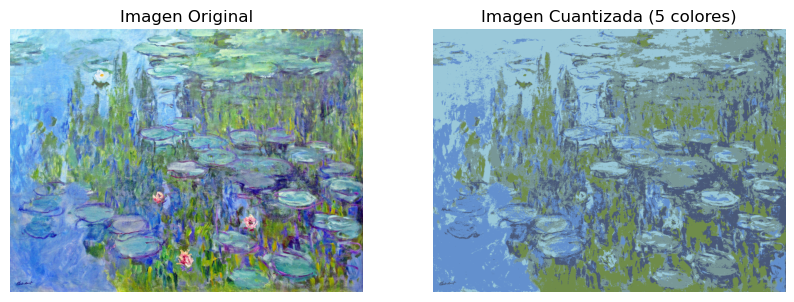

In [225]:
import matplotlib.pyplot as plt

# Reemplazar cada píxel con el color del cluster al que pertenece
quantized_image = colors[labels].reshape(image.shape)

# Mostrar la imagen original y la imagen cuantizada
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Imagen original
ax[0].imshow(image)
ax[0].set_title('Imagen Original')
ax[0].axis('off')

# Imagen cuantizada
ax[1].imshow(quantized_image)
ax[1].set_title(f'Imagen Cuantizada ({num_clusters} colores)')
ax[1].axis('off')

plt.show()